# BLU15 - Model CSI

## Intro:

It often happens that your data distribution changes with time. 

More than that, sometimes you don't know how a model was trained and what was the original training data. 

In this learning unit we're going to try to identify whether an existing model meets our expectations and redeploy it. 

## Problem statement:
As an example, we're going to use the same problem that you met in the last BLU. 

You're already familiar with the problem, but just as a reminder:

> The police department has received lots of complaints about its stop and search policy. Every time a car is stopped, the police officers have to decide whether or not to search the car for contraband. According to critics, these searches have a bias against people of certain backgrounds.

You got a model from your client, and **here is the model's description:**

> It's a LightGBM model (LGBMClassifier) trained on the following features:
> - Department Name
> - InterventionLocationName
> - InterventionReasonCode
> - ReportingOfficerIdentificationID
> - ResidentIndicator
> - SearchAuthorizationCode
> - StatuteReason
> - SubjectAge
> - SubjectEthnicityCode
> - SubjectRaceCode
> - SubjectSexCode
> - TownResidentIndicator

> All the categorical feature were one-hot encoded. The only numerical feature (SubjectAge) was not changed. The rows that contain rare categorical features (the ones that appear less than N times in the dataset) were removed. Check the original_model.ipynb notebook for more details.

P.S., if you never heard about lightgbm, XGboost and other gradient boosting, I highly recommend you to read this [article](https://mlcourse.ai/articles/topic10-boosting/) or watch these videos: [part1](https://www.youtube.com/watch?v=g0ZOtzZqdqk), [part2](https://www.youtube.com/watch?v=V5158Oug4W8)

It's not essential for this BLU, so you might leave this link as a desert after you go through the learning materials and solve the exercises, but these are very good models you can use later on, so I suggest reading about them. 

**Here are the requirements that the police department created:**

> - A minimum 50% success rate for searches (when a car is searched, it should be at least 50% likely that contraband is found)
> - No police sub-department should have a discrepancy bigger than 5% between the search success rate between protected classes (race, ethnicity, gender)  
> - The largest possible amount of contraband found, given the constraints above. 

**And here is the description of how the current model succeeds with the requirements:**

- precision score = 50%
- recall = 89.3%
- roc_auc_score for the probability predictions = 82.7%

The precision and recall above are met for probability predictions with a specified threshold equal to **0.21073452797732833**

It's not said whether the second requirement is met, and as it was not met in the previous learning unit, let's ignore it for now. 

## Model diagnosing:


Let's firstly try to compare these models to the ones that we created in the previous BLU:



| Model |   Baseline    |  Second iteration   | New model  | Best model |
|-------------------|---------|--------|--------|--------| 
| Requirement 1 - success rate |     0.53  |  0.38  |   0.5 |  1 |
| Requirement 2 - global discrimination (race) |  0.105  |  0.11  |  NaN  |  1 |
| Requirement 2 - global discrimination (sex) | 0.012  | 0.014 |  NaN  | 1 |
| Requirement 2 - global discrimination (ethnicity) | 0.114  |  0.101   |  NaN  | 2 | 
| Requirement 2 - # department discrimination (race) | 27 |  17 |  NaN  | 2 |
| Requirement 2 - # department discrimination (sex) | 19 |  23 |  NaN  | 1 |
| Requirement 2 - # department discrimination (ethnicity) | 24 |  NaN  |  23  | 2 |
| Requirement 3 - contraband found (Recall) | 0.65  | 0.76  |   0.893   | 3 | 


As we can see, the last model has the exact required success rate (Requirement 1) as we need, and a very good Recall (Requirement 3).

But it might be risky to have such a specific threshold, as we might end up success rate < 0.5 really quickly. It might be a better idea to have a bigger threshold (e.g. 0.25), but let's see.

Let's imagine that the model was trained long time ago.

And now you're in the future trying to evaluate the model, because things might have changed. Data distribution is not always the same, so something that used to work even a year ago could be completely wrong today. 

Especially in 2020!

<img src="media/future_2020.jpg" width=400/>

First of all, let's start the server which is running this model.

Open the shell,  

```sh

python protected_server.py


```

And read a csv files with new observations from 2020:

In [1]:
import joblib
import pandas as pd
import json
import joblib
import pickle
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
df = pd.read_csv('./data/new_observations.csv')

In [3]:
df.head()

,ContrabandIndicator,Department Name,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,farmington,unionville,V,400,False,I,Other,21,N,W,M,False
1,False,suffield,suffield,V,114,True,I,Registration,36,N,W,M,False
2,True,csp troop g,new haven,V,1000003362,True,C,Moving Violation,21,H,W,M,False
3,True,new canaan,new canaan,E,287,False,O,Defective Lights,14,H,W,M,True
4,False,stamford,stamford,V,3A NIGHTS,True,C,Seatbelt,37,N,W,M,False


Let's start from sending all those requests and comparing the model prediction results with the target values.

The model is already prepared to convert our observations to the format its expecting, the only thing we need to change is making department and intervention location names lowercase, and we're good to extract fields from the dataframe and put them to the post request.

In [4]:
# lowercaes departments and location names
df['Department Name'] = df['Department Name'].apply(lambda x: str(x).lower())
df['InterventionLocationName'] = df['InterventionLocationName'].apply(lambda x: str(x).lower())

In [5]:
url = "http://127.0.0.1:5000/predict"
headers = {'Content-Type': 'application/json'}

In [6]:
def send_request(index: int, obs: dict, url: str, headers: dict):
    observation = {
      "id": index,
      "observation": {
          "Department Name": obs["Department Name"],
          "InterventionLocationName": obs["InterventionLocationName"],
          "InterventionReasonCode": obs["InterventionReasonCode"],
          "ReportingOfficerIdentificationID": obs["ReportingOfficerIdentificationID"],
          "ResidentIndicator": obs["ResidentIndicator"],
          "SearchAuthorizationCode": obs["SearchAuthorizationCode"],
          "StatuteReason": obs["StatuteReason"],
          "SubjectAge": obs["SubjectAge"],
          "SubjectEthnicityCode": obs["SubjectEthnicityCode"],
          "SubjectRaceCode": obs["SubjectRaceCode"],
          "SubjectSexCode": obs["SubjectSexCode"],
          "TownResidentIndicator": obs["TownResidentIndicator"]
      }
    }

    r = requests.post(url, data=json.dumps(observation), headers=headers)
    result = json.loads(r.text)
    return result

In [8]:
responses = [send_request(i, obs, url, headers) for i, obs in df.iterrows()]

In [9]:
print(responses[0])

{'prediction': False, 'proba': 0.20558802427270148}


In [10]:
df['proba'] = [r['proba'] for r in responses]
threshold = 0.21073452797732833
# we're going to use the threshold we got from the client
df['prediction'] = [1 if p >= threshold else 0 for p in df['proba']]

**NOTE:** We could also load the model and make predictions locally (without using the api), but:

1. I wanted to show you how you might send requests in a similar situation
2. If you have a running API and some model file, you always need to understand how the API works (if it makes any kind of data preprocessing), which might sometimes be complicated, and if you're trying to analyze the model running in production, you still need to make sure that the local predictions you do are equal to the one that the production api does.

In [11]:
confusion_matrix(df['ContrabandIndicator'], df['prediction'])

array([[491, 697],
       [305, 507]])

If you're not familiar with confusion matrixes, **here is an explanation of the values:**

<img src="./media/confusion_matrix.jpg" alt="drawing" width="500"/>



These values don't seem to be good. Let's once again take a look on the client's requirements and see if we still meet them:

> A minimum 50% success rate for searches (when a car is searched, it should be at least 50% likely that contraband is found)


In [12]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.5):
    """
    Verifies the success rate on a test set is above a provided minimum

    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision


In [13]:
verify_success_rate_above(df['ContrabandIndicator'], df['prediction'], 0.5)

(False, 0.4210963455149502)

![No please](./media/no_please.jpg)

> The largest possible amount of contraband found, given the constraints above.

As the client says, their model recall was 0.893. And what now?

In [14]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred, pos_label=True)    
    return recall


In [15]:
verify_amount_found(df['ContrabandIndicator'], df['prediction'])

0.624384236453202

<img src="./media/no_please_2.jpg" alt="drawing" width="500"/>


Okay, relax, it happens. Let's start from checking different thresholds. Maybe the selected threshold was to specific and doesn't work anymore. 
What about 0.25?

In [16]:
threshold = 0.25
df['prediction'] = [1 if p >= threshold else 0 for p in df['proba']]

In [17]:
verify_success_rate_above(df['ContrabandIndicator'], df['prediction'], 0.5)

(False, 0.4155339805825243)

In [18]:
verify_amount_found(df['ContrabandIndicator'], df['prediction'])

0.5270935960591133

<img src="./media/poker.jpg" alt="drawing" width="200"/>

Okay, let's try the same technique to identify the best threshold as they originally did. Maybe we find something good enough.

It's not a good idea to verify such things on the test data, but we're going to use it just to confirm the model's performance, not to select the threshold.

In [19]:
precision, recall, thresholds = precision_recall_curve(df['ContrabandIndicator'], df['proba'])

In [20]:
precision = precision[:-1]
recall = recall[:-1]

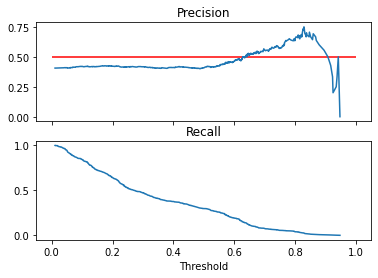

In [28]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

So what do we see? There is some threshold value (around 0.6) that gives us precision >= 0.5. 

But the threshold is so big, that the recall at this point is really-really low. 

Let's calculate the exact values:

In [21]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
print(min_index)

1474


In [22]:
thresholds[min_index]

0.6303488542579802

In [23]:
precision[min_index]

0.5

In [24]:
recall[min_index]

0.1477832512315271

<img src="./media/incredible.jpg" alt="drawing" width="400"/>


Before we move on, we need to understand why this happens, so that we can decide what kind of action to perform.

Let's try to analyze the changes in data and discuss different things we might want to do.

In [25]:
old_df = pd.read_csv('./data/train_searched.csv')

In [26]:
old_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,True,False,Bridgeport,10/01/2013 12:46:00 AM,Bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
1,True,True,Milford,10/01/2013 01:50:00 AM,MILFORD,E,2325,True,I,Defective Lights,30.0,N,W,M,True
2,True,False,Torrington,10/01/2013 03:49:00 AM,Torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True
3,True,False,State Police,10/01/2013 05:30:00 AM,TOLLAND,V,1000002715,False,C,Other,19.0,N,B,M,False
4,True,False,Greenwich,10/01/2013 05:47:00 AM,RIVERSIDE,V,110993,False,N,Speed Related,34.0,M,B,M,False


We're going to apply the same changes to the dataset as in the original model notebook unit to understand what was the original data like and how the current dataset differs.

In [27]:
old_df = old_df[(old_df['VehicleSearchedIndicator']==True)]

In [28]:
# lowercaes departments and location names
old_df['Department Name'] = old_df['Department Name'].apply(lambda x: str(x).lower())
old_df['InterventionLocationName'] = old_df['InterventionLocationName'].apply(lambda x: str(x).lower())

In [29]:
train_features = old_df.columns.drop(['VehicleSearchedIndicator', 'ContrabandIndicator'])
categorical_features = train_features.drop(['InterventionDateTime', 'SubjectAge'])
numerical_features = ['SubjectAge']
target = 'ContrabandIndicator'

In [30]:
# I'm going to remove less common features. 
# Let's create a dictionary with the minimum required number of appearences
min_frequency = {
    "Department Name": 50,
    "InterventionLocationName": 50,
    "ReportingOfficerIdentificationID": 30,
    "StatuteReason": 10
}

In [31]:
def filter_values(df: pd.DataFrame, column_name: str, threshold: int):
    value_counts = df[column_name].value_counts()
    to_keep = value_counts[value_counts > threshold].index
    filtered = df[df[column_name].isin(to_keep)]
    return filtered

In [32]:
for feature, threshold in min_frequency.items():
    old_df = filter_values(old_df, feature, threshold)

In [33]:
old_df.shape

(45334, 15)

In [34]:
old_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,True,False,bridgeport,10/01/2013 12:46:00 AM,bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
1,True,True,milford,10/01/2013 01:50:00 AM,milford,E,2325,True,I,Defective Lights,30.0,N,W,M,True
3,True,False,state police,10/01/2013 05:30:00 AM,tolland,V,1000002715,False,C,Other,19.0,N,B,M,False
11,True,True,state police,10/01/2013 12:41:00 PM,bridgeport,V,1000001904,True,O,Registration,20.0,N,B,M,True
12,True,True,west hartford,10/01/2013 12:44:00 PM,west hartford,V,1000002128,True,O,Other,23.0,N,W,M,False


In [35]:
old_df['ContrabandIndicator'].value_counts(normalize=True)

False    0.668593
True     0.331407
Name: ContrabandIndicator, dtype: float64

In [36]:
df['ContrabandIndicator'].value_counts(normalize=True)

False    0.594
True     0.406
Name: ContrabandIndicator, dtype: float64

Looks like we got a bit more contraband now, and it's already a good sign:

if the training data had a different target feature distribution than the test set, the model's predictions might have a different distribution as well. It's a good practice to have the same target feature distribution both in training and test sets. 

Let's investigate further

In [37]:
new_department_names = df['Department Name'].unique()
old_department_names = old_df['Department Name'].unique()

unknown_departments = [department for department in new_department_names if department not in old_department_names]
len(unknown_departments)

10

In [38]:
df[df['Department Name'].isin(unknown_departments)].shape

(23, 15)

So we have 10 departments that the original model was not trained on, but they are only 23 rows from the test set. 

Let's repeat the same thing for the Intervention Location names

In [39]:
new_location_names = df['InterventionLocationName'].unique()
old_location_names = old_df['InterventionLocationName'].unique()

unknown_locations = [location for location in new_location_names if location not in old_location_names]
len(unknown_locations)

73

In [40]:
df[df['InterventionLocationName'].isin(unknown_locations)].shape[0]

106

In [41]:
print('unknown locations: ', df[df['InterventionLocationName'].isin(unknown_locations)].shape[0] * 100 / df.shape[0], '%')

unknown locations:  5.3 %


Alright, a bit more of unknown locations. 

We don't know if the feature was important for the model, so these 5.3% of unknown locations might be important or not.

But it's worth keeping it in mind. 

**Here are a few ideas of what we could try to do:**

1. Reanalyze the filtered locations, e.g. filter more rare ones.
2. Create a new category for the rare locations
3. Analyze the unknown locations for containing typos

Let's go further and take a look on the relation between department names and the number of contrabands they find.

We're going to select the most common department names, and then see the percentage of contraband indicator in each one for the training and test sets

In [42]:
common_departments = df['Department Name'].value_counts().head(20).index

In [43]:
departments_new = df[df['Department Name'].isin(common_departments)]
departments_old = old_df[old_df['Department Name'].isin(common_departments)]

In [44]:
pd.crosstab(departments_new['ContrabandIndicator'], departments_new['Department Name'], normalize="columns")

Department Name,bridgeport,csp troop a,csp troop g,danbury,east hartford,enfield,glastonbury,manchester,new haven,norwalk,norwich,stamford,state police,stratford,vernon,wallingford,waterbury,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.621622,0.527778,0.547619,0.540541,0.632653,0.5,0.75,0.65625,0.587719,0.729167,0.535714,0.666667,0.638298,0.583333,0.542857,0.538462,0.66129,0.426471,0.727273,0.516129
True,0.378378,0.472222,0.452381,0.459459,0.367347,0.5,0.25,0.34375,0.412281,0.270833,0.464286,0.333333,0.361702,0.416667,0.457143,0.461538,0.33871,0.573529,0.272727,0.483871


In [45]:
pd.crosstab(departments_old['ContrabandIndicator'], departments_old['Department Name'], normalize="columns")

Department Name,bridgeport,csp troop a,csp troop g,danbury,east hartford,enfield,glastonbury,manchester,new haven,norwalk,norwich,stamford,state police,stratford,vernon,wallingford,waterbury,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.928666,0.661558,0.685864,0.928372,0.557677,0.658889,0.692217,0.51145,0.919422,0.653846,0.683516,0.834951,0.656923,0.718507,0.455538,0.466928,0.904637,0.33881,0.886396,0.568058
True,0.071334,0.338442,0.314136,0.071628,0.442323,0.341111,0.307783,0.48855,0.080578,0.346154,0.316484,0.165049,0.343077,0.281493,0.544462,0.533072,0.095363,0.66119,0.113604,0.431942


We can clearly see that some departments got a huge difference in the contraband indicator.

E.g. Bridgeport used to have 93% of False contrabands, and now has only 62%.

Similar situation with Danbury and New Haven. 

Why? Hard to say. There are really a lot of variables here. Maybe the departments got instructed on how to look for contraband. 

But we might need to retrain the model. 

Let's just finish reviewing other columns.

In [46]:
common_location = df['InterventionLocationName'].value_counts().head(20).index

In [47]:
locations_new = df[df['InterventionLocationName'].isin(common_location)]
locations_old = old_df[old_df['InterventionLocationName'].isin(common_location)]

In [48]:
pd.crosstab(locations_new['ContrabandIndicator'], locations_new['InterventionLocationName'], normalize="columns")

InterventionLocationName,bridgeport,danbury,east hartford,enfield,glastonbury,manchester,new britain,new haven,norwalk,norwich,stamford,stratford,torrington,vernon,wallingford,waterbury,west hartford,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.607843,0.589744,0.636364,0.5,0.75,0.65625,0.545455,0.576923,0.727273,0.526316,0.657895,0.547619,0.5,0.555556,0.552239,0.613333,0.378378,0.53125,0.714286,0.53125
True,0.392157,0.410256,0.363636,0.5,0.25,0.34375,0.454545,0.423077,0.272727,0.473684,0.342105,0.452381,0.5,0.444444,0.447761,0.386667,0.621622,0.46875,0.285714,0.46875


In [49]:
pd.crosstab(locations_old['ContrabandIndicator'], locations_old['InterventionLocationName'], normalize="columns")

InterventionLocationName,bridgeport,danbury,east hartford,enfield,glastonbury,manchester,new britain,new haven,norwalk,norwich,stamford,stratford,torrington,vernon,wallingford,waterbury,west hartford,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.844987,0.815315,0.559696,0.657609,0.693995,0.513612,0.553073,0.883483,0.574909,0.68172,0.829851,0.708615,0.62987,0.460413,0.467626,0.895877,0.304481,0.398274,0.865169,0.577997
True,0.155013,0.184685,0.440304,0.342391,0.306005,0.486388,0.446927,0.116517,0.425091,0.31828,0.170149,0.291385,0.37013,0.539587,0.532374,0.104123,0.695519,0.601726,0.134831,0.422003


What do we see? First of all, the InterventionLocationName and the Department Name are often same.

It sounds pretty logic, as probably policeman's usually work in the area of their department. But we could try to create a feature saying whether InterventionLocationName is equal to the Department Name.

Or maybe we could just get rid of one of them, if all the values are equal. 

What else?

Well, There are similar changes in the Contraband distribution as in Department Name case.

Let's move on:

In [50]:
pd.crosstab(df['ContrabandIndicator'], df['InterventionReasonCode'], normalize="columns")

InterventionReasonCode,E,I,V
ContrabandIndicator,,,
False,0.598187,0.623457,0.589914
True,0.401813,0.376543,0.410086


In [51]:
pd.crosstab(old_df['ContrabandIndicator'], old_df['InterventionReasonCode'], normalize="columns")

InterventionReasonCode,E,I,V
ContrabandIndicator,,,
False,0.649064,0.650335,0.674872
True,0.350936,0.349665,0.325128


There are some small changes, but they don't seem to be significant. 

Especially that all the 3 values have around 33% of Contraband.

Time for officers:

In [52]:
df['ReportingOfficerIdentificationID'].value_counts()

1000002072    13
790642042     12
625           10
30252          9
30233          8
              ..
KPARENT        1
110989         1
500            1
854730376      1
681608887      1
Name: ReportingOfficerIdentificationID, Length: 1166, dtype: int64

In [53]:
filter_values(df, 'ReportingOfficerIdentificationID', 2)['ReportingOfficerIdentificationID'].nunique()

206

Well, looks like there are a lot of unique values for the officer id (1166 for 2000 records), and there are not so many common ones (only 206 officers have more than 2 rows in the dataset) so it doesn't make much sense to analyze it.

Let's quickly go throw the rest of the columns:

In [54]:
df.columns

Index(['ContrabandIndicator', 'Department Name', 'InterventionLocationName',
       'InterventionReasonCode', 'ReportingOfficerIdentificationID',
       'ResidentIndicator', 'SearchAuthorizationCode', 'StatuteReason',
       'SubjectAge', 'SubjectEthnicityCode', 'SubjectRaceCode',
       'SubjectSexCode', 'TownResidentIndicator', 'proba', 'prediction'],
      dtype='object')

In [55]:
rest = ['ResidentIndicator', 'SearchAuthorizationCode',
        'StatuteReason', 'SubjectEthnicityCode',
        'SubjectRaceCode', 'SubjectSexCode','TownResidentIndicator']

for col in rest:
    display(pd.crosstab(df['ContrabandIndicator'], df[col], normalize="columns"))
    display(pd.crosstab(old_df['ContrabandIndicator'], old_df[col], normalize="columns"))

ResidentIndicator,False,True
ContrabandIndicator,,
False,0.604775,0.58748
True,0.395225,0.41252


ResidentIndicator,False,True
ContrabandIndicator,,
False,0.625359,0.672186
True,0.374641,0.327814


SearchAuthorizationCode,C,I,N,O
ContrabandIndicator,,,,
False,0.569602,0.642857,0.635417,0.585642
True,0.430398,0.357143,0.364583,0.414358


SearchAuthorizationCode,C,I,N,O
ContrabandIndicator,,,,
False,0.752934,0.894521,0.861478,0.457862
True,0.247066,0.105479,0.138522,0.542138


StatuteReason,Administrative Offense,Cell Phone,Defective Lights,Display of Plates,Equipment Violation,Moving Violation,Other,Other/Error,Registration,STC Violation,Seatbelt,Speed Related,Stop Sign,Suspended License,Traffic Control Signal,Unlicensed Operation,Window Tint
ContrabandIndicator,,,,,,,,,,,,,,,,,
False,0.653543,0.519231,0.593607,0.659722,0.458333,0.521552,0.618705,0.698113,0.626214,0.55,0.54386,0.565574,0.583333,0.536585,0.55914,0.529412,0.670588
True,0.346457,0.480769,0.406393,0.340278,0.541667,0.478448,0.381295,0.301887,0.373786,0.45,0.45614,0.434426,0.416667,0.463415,0.44086,0.470588,0.329412


StatuteReason,Administrative Offense,Cell Phone,Defective Lights,Display of Plates,Equipment Violation,Moving Violation,Other,Other/Error,Registration,STC Violation,Seatbelt,Speed Related,Stop Sign,Suspended License,Traffic Control Signal,Unlicensed Operation,Window Tint
ContrabandIndicator,,,,,,,,,,,,,,,,,
False,0.750151,0.665208,0.630577,0.663895,0.582386,0.623213,0.616824,0.643369,0.791045,0.75082,0.583156,0.617579,0.686157,0.843185,0.714509,0.79726,0.666667
True,0.249849,0.334792,0.369423,0.336105,0.417614,0.376787,0.383176,0.356631,0.208955,0.24918,0.416844,0.382421,0.313843,0.156815,0.285491,0.20274,0.333333


SubjectEthnicityCode,H,M,N
ContrabandIndicator,,,
False,0.617068,0.730769,0.584707
True,0.382932,0.269231,0.415293


SubjectEthnicityCode,H,M,N
ContrabandIndicator,,,
False,0.72291,0.687805,0.651621
True,0.27709,0.312195,0.348379


SubjectRaceCode,A,B,I,W
ContrabandIndicator,,,,
False,0.578947,0.603648,0.571429,0.59008
True,0.421053,0.396352,0.428571,0.40992


SubjectRaceCode,A,B,I,W
ContrabandIndicator,,,,
False,0.687273,0.706417,0.706897,0.651785
True,0.312727,0.293583,0.293103,0.348215


SubjectSexCode,F,M
ContrabandIndicator,,
False,0.561828,0.601351
True,0.438172,0.398649


SubjectSexCode,F,M
ContrabandIndicator,,
False,0.682614,0.665461
True,0.317386,0.334539


TownResidentIndicator,False,True
ContrabandIndicator,,
False,0.6,0.587368
True,0.4,0.412632


TownResidentIndicator,False,True
ContrabandIndicator,,
False,0.645803,0.702954
True,0.354197,0.297046


We see that all the columns got changes, but they don't seem to be so significant as in the Departments cases.

Anyway, it seems like we need to retrain the model.

<img src="./media/retrain.jpg" alt="drawing" width="400"/>

Retraining a model is always a decision we need to think about.

Was this change in data constant, temporary or seasonal?

In other words, do we expect the data distribution to stay as it is? To change back after Covid? To change from season to season? 

**Depending on that, we could retrain the model differently:**

- **If it's a seasonality**, we might want to add features like season or month and train the same model to predict differently depending on the season. We could also investigate time-series classification algorithms.

- **If it's something that is going to change back**, we might either train a new model for this particular period in case the current data distrubution changes were temporary. Otherwise, if we expect the data distribution change here and back from time to time (and we know these periods in advance), we could create a new feature that would help model understand which period it is.

> E.g. if we had a task of predicting beer consumption and had a city that has a lot of football matches, we might add a feature like **football_championship** and make the model predict differently for this occasions. 

- **If the data distribution has simply changed and we know that it's never going to come back**, we can simply retrain the model.

> But in some cases we have no idea why some changes appeared (e.g. in this case of departments having more contraband).

- In this case it might be a good idea to train a new model on the new datast and create some monitoring for these features distribution, so we could react when things change. 

> So, in our case we don't know what was the reason of data distribution changes, so we'd like to train a model on the new dataset. 

> The only thing is the size of the dataset. Original dataset had around 50k rows, and our new set has only 2000. It's not enough to train a good model, so this time we're going to combine both the datasets and add a new feature helping model to distinguish between them. If we had more data, it would be probably better to train a completely new model.

And we're done!

<img src="./media/end.jpg" alt="drawing" width="400"/>
